In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/polyadb_features_pas_3_utr3_isoforms.csv', sep='\t')

save_dict = np.load("../../aparent/data/polyadb_features_pas_3_utr3_isoforms_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/polyadb_features_pas_3_utr3_isoforms_saluki_dense_full.npz")
hl, hl_m = save_dict['hl'], save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['rpm'], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes
cell_type = 'rpm'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

s = np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_isoforms.npy')
s_all_cuts = np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_isoform_all_cuts.npy')

#Mask out a-rich APARENT2 scores
#s[a_rich > 0] = np.min(s)

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (202,203,205,206,211,212,214,215,220,221,223,224,229,230,232,233,238,239,241,242,247,248,250,251,256,257,259,260,265,266,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


s.shape = (10415, 30)
m.shape = (10415, 30)
l.shape = (10415, 30)
y.shape = (10415, 30)
c.shape = (10415, 30)

hl.shape = (10415, 30, 50, 64)
hl_m.shape = (10415, 30)
a_rich.shape = (10415, 30)


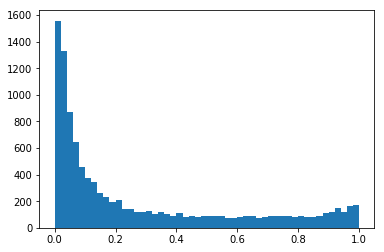

In [3]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [4]:
#Construct PAS-to-matrix-coord dictionary

gene_dict = {}
gene_id_dict = {}
gene_distal_cut_pos_dict = {}

gene_cut_pos_dict = {}

genes = []
gene_ids = []

i = 0
for _, row in df.iterrows() :
    gene_dict[row['gene']] = i
    genes.append(row['gene'])
    gene_distal_cut_pos_dict[row['gene']] = row['cut_mode_' + str(dist_index[i])]
    
    cut_poses = []
    
    for j in range(m.shape[1]) :
        if m[i, j] > 0. :
            gene_id_dict[row['gene_id_' + str(j)]] = j
            gene_ids.append(row['gene_id_' + str(j)])
            cut_poses.append(row['cut_mode_' + str(j)])
    
    gene_cut_pos_dict[row['gene']] = np.array(cut_poses)
    
    i += 1

print("gene_dict['ABCB10'] = " + str(gene_dict['ABCB10']))
print("gene_id_dict['ABCB10.6'] = " + str(gene_id_dict['ABCB10.6']))
print("gene_distal_cut_pos_dict['ABCB10'] = " + str(gene_distal_cut_pos_dict['ABCB10']))
print("gene_cut_pos_dict['ABCB10'] = " + str(gene_cut_pos_dict['ABCB10']))


gene_dict['ABCB10'] = 0
gene_id_dict['ABCB10.6'] = 0
gene_distal_cut_pos_dict['ABCB10'] = 229652139.0
gene_cut_pos_dict['ABCB10'] = [2.29653545e+08 2.29652589e+08 2.29652545e+08 2.29652329e+08
 2.29652175e+08 2.29652139e+08]


In [5]:

def _get_distal_ix(qtl_cut_pos, cut_poses, cutoff_dist=50) :
    
    cands = np.nonzero(np.abs(cut_poses - qtl_cut_pos) <= cutoff_dist)[0]
    
    return cands[-1] if len(cands) > 0 else -1


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [7]:
#Assign all-cut logit to distal-most PAS

for i in range(s.shape[0]) :
    s[i, dist_index[i]] = s_all_cuts[i, dist_index[i]]


In [8]:
#Reduce half-life feature dims with PCA

from sklearn.decomposition import PCA

pcas = []
hl_pcas = []

for model_ix in range(hl.shape[2]) :

    flat_hl = np.array(np.reshape(hl[..., model_ix, :], (hl.shape[0] * hl.shape[1], hl.shape[3])), dtype=np.float32)
    flat_hl_m = np.array(np.reshape(hl_m, (hl.shape[0] * hl.shape[1],)), dtype=np.float32)

    pca = PCA(n_components=4).fit(flat_hl[flat_hl_m >= 1., ...])

    print("Model " + str(model_ix) + ", Fraction of variance explaned = " + str(round(np.sum(pca.explained_variance_ratio_), 3)))

    flat_hl_pca = pca.transform(flat_hl) * flat_hl_m[:, None]
    hl_pca = np.reshape(flat_hl_pca, (hl.shape[0], hl.shape[1], flat_hl_pca.shape[1]))

    print(hl_pca.shape)
    
    pcas.append(pca)
    hl_pcas.append(hl_pca)


Model 0, Fraction of variance explaned = 0.96
(10415, 30, 4)
Model 1, Fraction of variance explaned = 0.977
(10415, 30, 4)
Model 2, Fraction of variance explaned = 0.98
(10415, 30, 4)
Model 3, Fraction of variance explaned = 0.969
(10415, 30, 4)
Model 4, Fraction of variance explaned = 0.968
(10415, 30, 4)
Model 5, Fraction of variance explaned = 0.953
(10415, 30, 4)
Model 6, Fraction of variance explaned = 0.971
(10415, 30, 4)
Model 7, Fraction of variance explaned = 0.97
(10415, 30, 4)
Model 8, Fraction of variance explaned = 0.958
(10415, 30, 4)
Model 9, Fraction of variance explaned = 0.979
(10415, 30, 4)
Model 10, Fraction of variance explaned = 0.981
(10415, 30, 4)
Model 11, Fraction of variance explaned = 0.974
(10415, 30, 4)
Model 12, Fraction of variance explaned = 0.978
(10415, 30, 4)
Model 13, Fraction of variance explaned = 0.969
(10415, 30, 4)
Model 14, Fraction of variance explaned = 0.965
(10415, 30, 4)
Model 15, Fraction of variance explaned = 0.974
(10415, 30, 4)
Model

Loading model 0...
weights = [ 0.49 -0.03 -0.31  0.43 -0.17  0.31 -0.08  0.08  2.33 -0.51 -0.02  0.84
  2.46 -1.53]
hl weights (prox) = [-0.08  0.08  2.33 -0.51]
hl weights (dist) = [-0.02  0.84  2.46 -1.53]
hl weight signs (prox) = [-1.  1.  1. -1.]
hl weight signs (dist) = [-1.  1.  1. -1.]

Loading model 1...
weights = [ 0.48 -0.   -0.1   0.42 -0.08  0.1   0.09  0.34 -1.73  0.71  0.14  0.03
 -2.16  0.54]
hl weights (prox) = [ 0.09  0.34 -1.73  0.71]
hl weights (dist) = [ 0.14  0.03 -2.16  0.54]
hl weight signs (prox) = [ 1.  1. -1.  1.]
hl weight signs (dist) = [ 1.  1. -1.  1.]

Loading model 2...
weights = [ 0.49 -0.02 -0.17  0.4  -0.13  0.17  0.05 -0.74 -1.76  0.17  0.14 -0.35
 -2.22 -0.54]
hl weights (prox) = [ 0.05 -0.74 -1.76  0.17]
hl weights (dist) = [ 0.14 -0.35 -2.22 -0.54]
hl weight signs (prox) = [ 1. -1. -1.  1.]
hl weight signs (dist) = [ 1. -1. -1. -1.]

Loading model 3...
weights = [ 0.48 -0.02 -0.16  0.42 -0.11  0.16  0.11  0.31  0.99  0.05  0.15 -0.15
  1.28 -0.35]

weights = [ 0.47 -0.01 -0.07  0.42 -0.07  0.07  0.12  0.51  1.16 -0.61  0.13  0.24
  1.71 -0.61]
hl weights (prox) = [ 0.12  0.51  1.16 -0.61]
hl weights (dist) = [ 0.13  0.24  1.71 -0.61]
hl weight signs (prox) = [ 1.  1.  1. -1.]
hl weight signs (dist) = [ 1.  1.  1. -1.]

Done!
Evaluating model 0...
Spearman r = 0.689
AP = 0.73
n = 10415


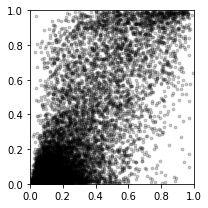

Evaluating model 1...
Spearman r = 0.691
AP = 0.74
n = 10415


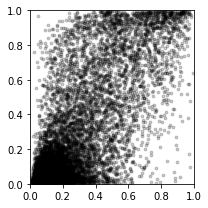

Evaluating model 2...
Spearman r = 0.695
AP = 0.73
n = 10415


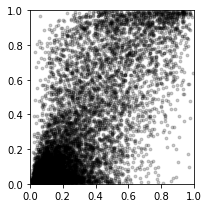

Evaluating model 3...
Spearman r = 0.688
AP = 0.73
n = 10415


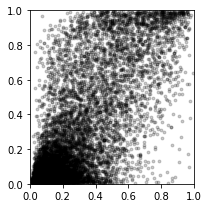

Evaluating model 4...
Spearman r = 0.683
AP = 0.73
n = 10415


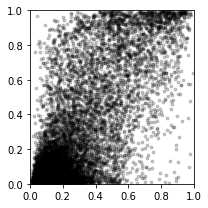

Evaluating model 5...
Spearman r = 0.689
AP = 0.73
n = 10415


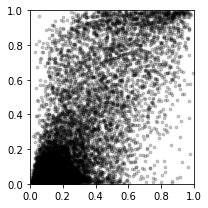

Evaluating model 6...
Spearman r = 0.694
AP = 0.73
n = 10415


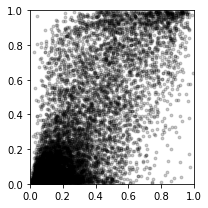

Evaluating model 7...
Spearman r = 0.697
AP = 0.73
n = 10415


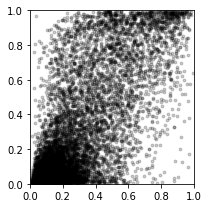

Evaluating model 8...
Spearman r = 0.694
AP = 0.73
n = 10415


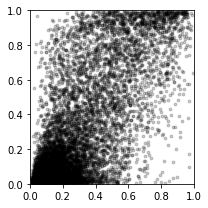

Evaluating model 9...
Spearman r = 0.682
AP = 0.72
n = 10415


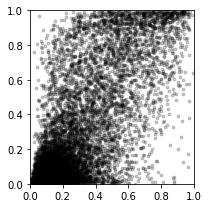

Evaluating model 10...
Spearman r = 0.691
AP = 0.73
n = 10415


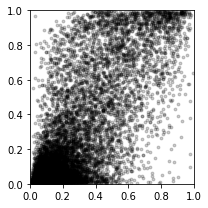

Evaluating model 11...
Spearman r = 0.687
AP = 0.72
n = 10415


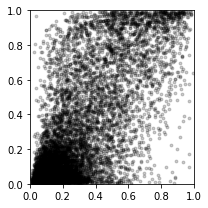

Evaluating model 12...
Spearman r = 0.696
AP = 0.74
n = 10415


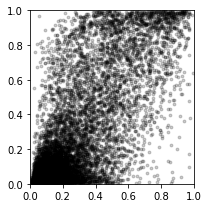

Evaluating model 13...
Spearman r = 0.687
AP = 0.73
n = 10415


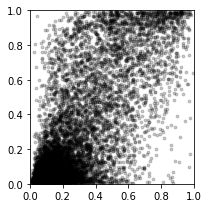

Evaluating model 14...
Spearman r = 0.69
AP = 0.73
n = 10415


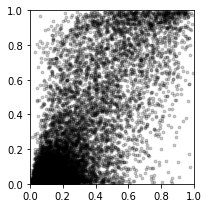

Evaluating model 15...
Spearman r = 0.696
AP = 0.73
n = 10415


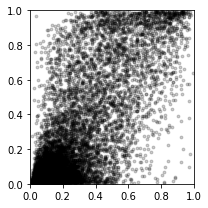

Evaluating model 16...
Spearman r = 0.688
AP = 0.73
n = 10415


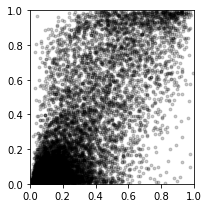

Evaluating model 17...
Spearman r = 0.685
AP = 0.73
n = 10415


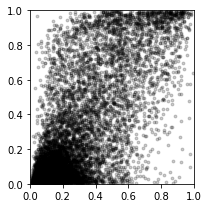

Evaluating model 18...
Spearman r = 0.689
AP = 0.73
n = 10415


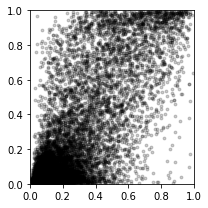

Evaluating model 19...
Spearman r = 0.686
AP = 0.73
n = 10415


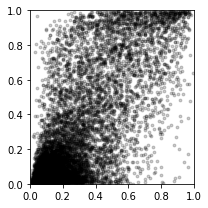

Evaluating model 20...
Spearman r = 0.689
AP = 0.73
n = 10415


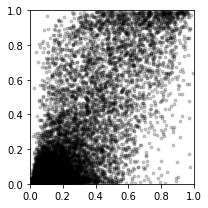

Evaluating model 21...
Spearman r = 0.678
AP = 0.72
n = 10415


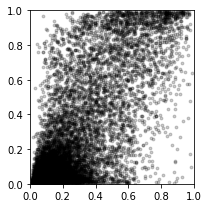

Evaluating model 22...
Spearman r = 0.698
AP = 0.73
n = 10415


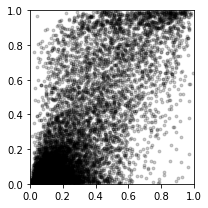

Evaluating model 23...
Spearman r = 0.692
AP = 0.74
n = 10415


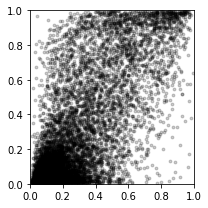

Evaluating model 24...
Spearman r = 0.692
AP = 0.73
n = 10415


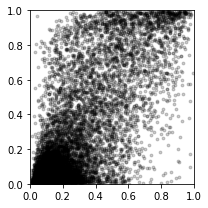

Evaluating model 25...
Spearman r = 0.695
AP = 0.73
n = 10415


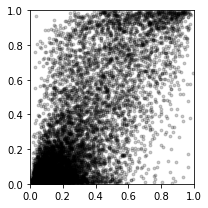

Evaluating model 26...
Spearman r = 0.686
AP = 0.73
n = 10415


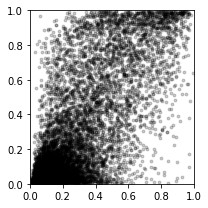

Evaluating model 27...
Spearman r = 0.686
AP = 0.72
n = 10415


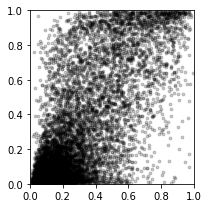

Evaluating model 28...
Spearman r = 0.689
AP = 0.73
n = 10415


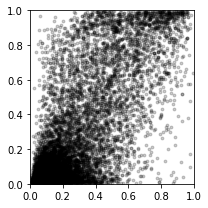

Evaluating model 29...
Spearman r = 0.693
AP = 0.73
n = 10415


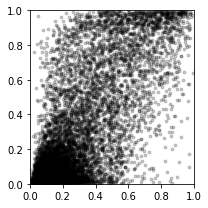

Evaluating model 30...
Spearman r = 0.691
AP = 0.73
n = 10415


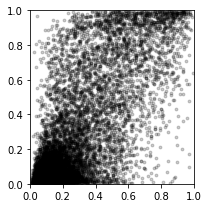

Evaluating model 31...
Spearman r = 0.682
AP = 0.72
n = 10415


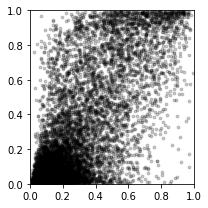

Evaluating model 32...
Spearman r = 0.676
AP = 0.72
n = 10415


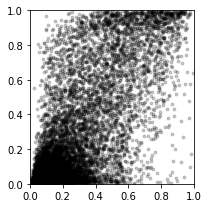

Evaluating model 33...
Spearman r = 0.689
AP = 0.73
n = 10415


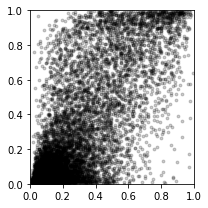

Evaluating model 34...
Spearman r = 0.685
AP = 0.73
n = 10415


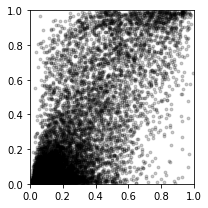

Evaluating model 35...
Spearman r = 0.699
AP = 0.74
n = 10415


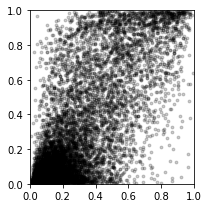

Evaluating model 36...
Spearman r = 0.681
AP = 0.73
n = 10415


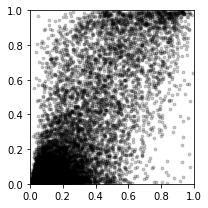

Evaluating model 37...
Spearman r = 0.693
AP = 0.74
n = 10415


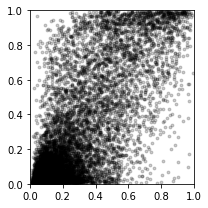

Evaluating model 38...
Spearman r = 0.684
AP = 0.73
n = 10415


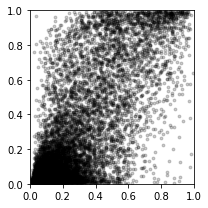

Evaluating model 39...
Spearman r = 0.687
AP = 0.73
n = 10415


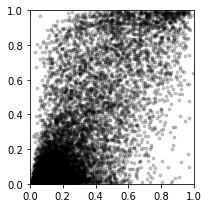

Evaluating model 40...
Spearman r = 0.686
AP = 0.73
n = 10415


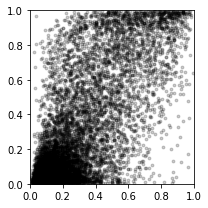

Evaluating model 41...
Spearman r = 0.682
AP = 0.73
n = 10415


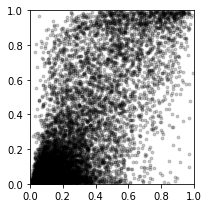

Evaluating model 42...
Spearman r = 0.697
AP = 0.73
n = 10415


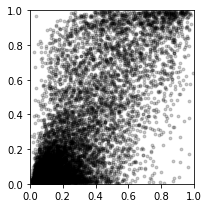

Evaluating model 43...
Spearman r = 0.695
AP = 0.73
n = 10415


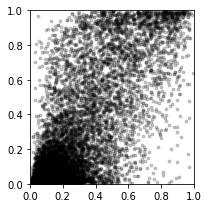

Evaluating model 44...
Spearman r = 0.688
AP = 0.73
n = 10415


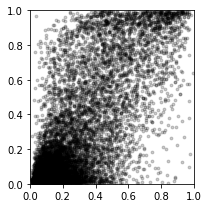

Evaluating model 45...
Spearman r = 0.693
AP = 0.73
n = 10415


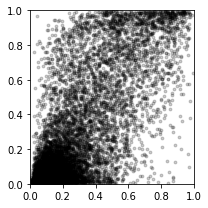

Evaluating model 46...
Spearman r = 0.696
AP = 0.73
n = 10415


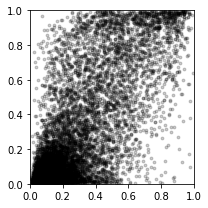

Evaluating model 47...
Spearman r = 0.685
AP = 0.73
n = 10415


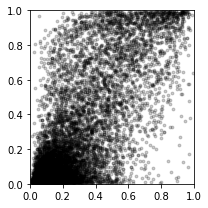

Evaluating model 48...
Spearman r = 0.685
AP = 0.73
n = 10415


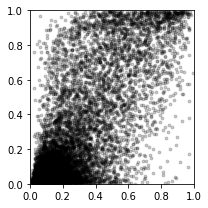

Evaluating model 49...
Spearman r = 0.692
AP = 0.73
n = 10415


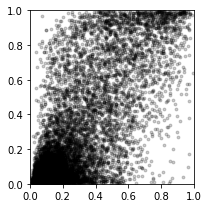

In [9]:
#Fit and evaluate regression model

from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score

load_model = True

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + np.sum(w_prox_hl[None, None, :] * hl, axis=-1) + w_prox_len * l + w_prox_bias)
    dist_exp = np.exp(w_dist_pas * s + np.sum(w_dist_hl[None, None, :] * hl, axis=-1) + w_dist_len * l + w_dist_bias)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_len = w_bundle[1]
    w_prox_bias = w_bundle[2]
    w_dist_pas = w_bundle[3]
    w_dist_len = w_bundle[4]
    w_dist_bias = w_bundle[5]
    w_prox_hl = w_bundle[6:6+hl.shape[2]] if w_bundle.shape[0] > 8 else w_bundle[6:7]
    w_dist_hl = w_bundle[6+hl.shape[2]:6+2*hl.shape[2]] if w_bundle.shape[0] > 8 else w_bundle[7:8]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

w_dicts = []

if not load_model :

    for model_ix in range(len(hl_pcas)) :
        
        print("Training model " + str(model_ix) + "...")

        w0 = np.zeros(6 + 2*hl_pcas[model_ix].shape[2])

        res = minimize(logistic_model_mse, w0, args=(s, hl_pcas[model_ix], m, l, dist_mask, y_dist), method='BFGS', options={'disp': False})

        np.save("aparent2_saluki_linear_polyadb_w_model_" + str(model_ix), np.array(res.x))
        
        w_dict = {}
        w_dict['w_prox_pas'] = res.x[0]
        w_dict['w_prox_len'] = res.x[1]
        w_dict['w_prox_bias'] = res.x[2]
        w_dict['w_dist_pas'] = res.x[3]
        w_dict['w_dist_len'] = res.x[4]
        w_dict['w_dist_bias'] = res.x[5]
        w_dict['w_prox_hl'] = res.x[6:6+hl_pcas[model_ix].shape[2]]
        w_dict['w_dist_hl'] = res.x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]]

        print("weights = " + str(np.round(res.x, 2)))

        print("hl weights (prox) = " + str(np.round(res.x[6:6+hl_pcas[model_ix].shape[2]], 2)))
        print("hl weights (dist) = " + str(np.round(res.x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]], 2)))

        print("hl weight signs (prox) = " + str(np.sign(res.x[6:6+hl_pcas[model_ix].shape[2]])))
        print("hl weight signs (dist) = " + str(np.sign(res.x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]])))
        print("")
        
        w_dicts.append(w_dict)

else :
    
    for model_ix in range(len(hl_pcas)) :
        
        print("Loading model " + str(model_ix) + "...")
    
        res_x = np.load("aparent2_saluki_linear_polyadb_w_model_" + str(model_ix) + ".npy")

        w_dict = {}
        w_dict['w_prox_pas'] = res_x[0]
        w_dict['w_prox_len'] = res_x[1]
        w_dict['w_prox_bias'] = res_x[2]
        w_dict['w_dist_pas'] = res_x[3]
        w_dict['w_dist_len'] = res_x[4]
        w_dict['w_dist_bias'] = res_x[5]
        w_dict['w_prox_hl'] = res_x[6:6+hl_pcas[model_ix].shape[2]]
        w_dict['w_dist_hl'] = res_x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]]
    
        print("weights = " + str(np.round(res_x, 2)))

        print("hl weights (prox) = " + str(np.round(res_x[6:6+hl_pcas[model_ix].shape[2]], 2)))
        print("hl weights (dist) = " + str(np.round(res_x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]], 2)))

        print("hl weight signs (prox) = " + str(np.sign(res_x[6:6+hl_pcas[model_ix].shape[2]])))
        print("hl weight signs (dist) = " + str(np.sign(res_x[6+hl_pcas[model_ix].shape[2]:6+2*hl_pcas[model_ix].shape[2]])))
        print("")
        
        w_dicts.append(w_dict)

print("Done!")


for model_ix in range(len(hl_pcas)) :
        
    print("Evaluating model " + str(model_ix) + "...")
    
    w_prox_pas = w_dicts[model_ix]['w_prox_pas']
    w_prox_len = w_dicts[model_ix]['w_prox_len']
    w_prox_bias = w_dicts[model_ix]['w_prox_bias']
    w_dist_pas = w_dicts[model_ix]['w_dist_pas']
    w_dist_len = w_dicts[model_ix]['w_dist_len']
    w_dist_bias = w_dicts[model_ix]['w_dist_bias']
    w_prox_hl = w_dicts[model_ix]['w_prox_hl']
    w_dist_hl = w_dicts[model_ix]['w_dist_hl']

    y_dist_pred = logistic_model_predict(s, hl_pcas[model_ix], m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)

    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)

    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])

    ap = average_precision_score(y_labels, y_dist_pred)

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [10]:
#Prediction interface

def _predict(s, hl, m, l, dist_mask, pca, w_dict) :
    
    w_prox_pas = w_dict['w_prox_pas']
    w_prox_hl = w_dict['w_prox_hl']
    w_prox_len = w_dict['w_prox_len']
    w_prox_bias = w_dict['w_prox_bias']
    w_dist_pas = w_dict['w_dist_pas']
    w_dist_hl = w_dict['w_dist_hl']
    w_dist_len = w_dict['w_dist_len']
    w_dist_bias = w_dict['w_dist_bias']
    
    flat_hl = np.reshape(hl, (hl.shape[0] * hl.shape[1], hl.shape[2]))
    flat_m = np.reshape(m, (hl.shape[0] * hl.shape[1],))

    flat_hl_pca = pca.transform(flat_hl) * flat_m[:, None]
    hl_pca = np.reshape(flat_hl_pca, (hl.shape[0], hl.shape[1], flat_hl_pca.shape[1]))
    
    return logistic_model_predict(s, hl_pca, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)


In [11]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Transformed_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Liver',
    'Lung',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


median spearman r = 0.65, n = 1486.0
median p-value = 2.6e-05, n = 1486.0
median significance AP = 0.512

unique snps = 357



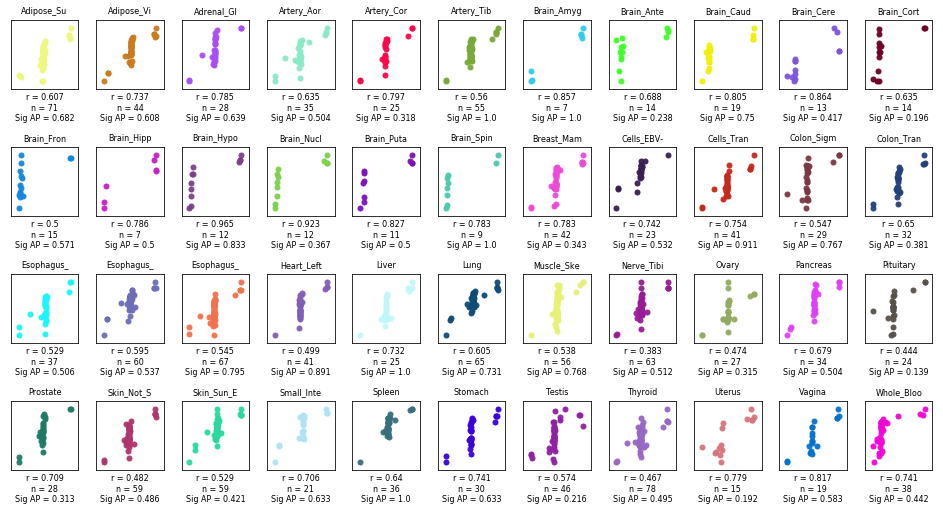

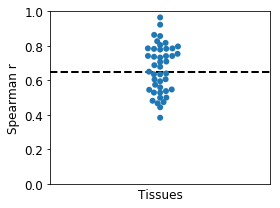

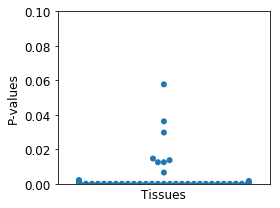

--- example tissue = 'Lung'
spearman r = 0.605
p-value = 9.209610944793222e-08
n = 65


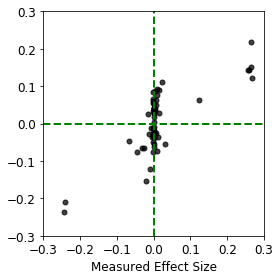

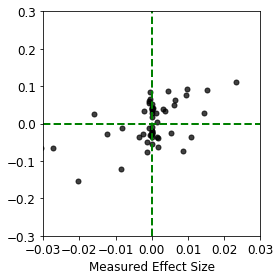

In [12]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = True

version_suffix = '_utr3_iso_lead_all_folds_aparent2_only_signed'

individual_plot_tissue_ix = tissue_types.index("Lung")

min_proximal_padding = 1e6
n_distal_padding = 0

hl_sign = 1.

significance_q = 0.9

keep_unmapped_snps = False

use_abs = False

rescale_polyadb = False

def _determine_distal_ix(row) :
    
    distal_ix = _get_distal_ix(row['qtl_cut_pos'], gene_cut_pos_dict[row['gene']], cutoff_dist=75)

    return distal_ix if distal_ix != -1 else (dist_index[gene_dict[row['gene']]] if keep_unmapped_snps else -1)

n_rows = 4
n_cols = 11

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

y_preds = []
y_trues = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_dict = {}

for tissue_i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df_pas = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_only_iso_predictions_pred_df.csv", sep='\t')
    snp_pred_df_pas = snp_pred_df_pas.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_iso = pd.read_csv("predictions/apa_gtex_data/isoform_merged_utr3_only_iso_lead_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')
    snp_pred_df_iso = snp_pred_df_iso.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_pas['snp_pos_pas'] = snp_pred_df_pas['rel_snp_pos'] - 105

    snp_pred_df_pas_orig = snp_pred_df_pas.copy()

    snp_pred_df_pas_distinct = snp_pred_df_pas.copy()
    snp_pred_df_pas_distinct['snp_pos_pas_dist'] = np.abs(snp_pred_df_pas_distinct['snp_pos_pas'] - 76)
    snp_pred_df_pas_distinct = snp_pred_df_pas_distinct.sort_values(by=['snp_pos_pas_dist'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

    snp_pred_df_iso = snp_pred_df_iso.join(snp_pred_df_pas_distinct[['snp_id', 'snp_pos_pas', 'wide_seq_ext', 'wide_seq_ext_var']].drop_duplicates(subset=['snp_id']).set_index('snp_id'), on='snp_id', how='left')
    snp_pred_df_iso.loc[snp_pred_df_iso['snp_pos_pas'].isnull(), 'snp_pos_pas'] = -1

    #snp_pred_df_iso = snp_pred_df_iso.query("snp_pos_pas < 70 or snp_pos_pas > 76").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.query("(snp_pos_pas < 70 or snp_pos_pas > 76) and snp_pos_pas != -1").copy().reset_index(drop=True)
    
    #snp_pred_df_pas = snp_pred_df_pas.query("gene == 'NO_GENE'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.query("gene == 'NO_GENE'").copy().reset_index(drop=True)

    #Get dataframe of unique SNPs
    snp_df = pd.concat([
        snp_pred_df_pas[['snp_id', 'gene_id', 'gene', 'pas', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
        snp_pred_df_iso[['snp_id', 'gene_id', 'gene', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
    ]).drop_duplicates(subset=['snp_id', 'transcript_id'], keep='first').sort_values(by='snp_id').copy().reset_index(drop=True)

    snp_df['distal_ix'] = snp_df.apply(_determine_distal_ix, axis=1)
    snp_df = snp_df.query("distal_ix != -1").copy().reset_index(drop=True)

    #Construct ref/var gene-level matrices for each snp
    s_ref, s_var = np.zeros((len(snp_df), s.shape[1])), np.zeros((len(snp_df), s.shape[1]))
    hl_ref, hl_var = np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3])), np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3]))
    m_ref, m_var = np.zeros((len(snp_df), m.shape[1])), np.zeros((len(snp_df), m.shape[1]))
    l_ref, l_var = np.zeros((len(snp_df), l.shape[1])), np.zeros((len(snp_df), l.shape[1]))
    dist_mask_ref, dist_mask_var = np.zeros((len(snp_df), dist_mask.shape[1])), np.zeros((len(snp_df), dist_mask.shape[1]))

    i = 0
    for _, row in snp_df.iterrows() :

        s_ref[i, :], s_var[i, :] = s[gene_dict[row['gene']], :], s[gene_dict[row['gene']], :]
        hl_ref[i, :], hl_var[i, :] = hl[gene_dict[row['gene']], :, :], hl[gene_dict[row['gene']], :, :]
        m_ref[i, :], m_var[i, :] = m[gene_dict[row['gene']], :], m[gene_dict[row['gene']], :]
        l_ref[i, :], l_var[i, :] = l[gene_dict[row['gene']], :], l[gene_dict[row['gene']], :]
        
        #dist_mask_ref[i, row['distal_ix']], dist_mask_var[i, row['distal_ix']] = 1., 1.
        dist_mask_ref[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1], dist_mask_var[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1] = 1., 1.

        #Fill in variant predictions
        snp_pred_df_pas_subset = snp_pred_df_pas.query("snp_id == '" + row['snp_id'] + "'")
        for _, pas_row in snp_pred_df_pas_subset.iterrows() :

            pred_suffix = '' if gene_id_dict[pas_row['gene_id']] != dist_index[gene_dict[pas_row['gene']]] else '_all_cuts'

            s_ref[i, gene_id_dict[pas_row['gene_id']]] = pas_row['ref_isoform_logodds' + pred_suffix]
            s_var[i, gene_id_dict[pas_row['gene_id']]] = pas_row['var_isoform_logodds' + pred_suffix]

        snp_pred_df_iso_subset = snp_pred_df_iso.query("snp_id == '" + row['snp_id'] + "'")
        for _, iso_row in snp_pred_df_iso_subset.iterrows() :

            model_ix = 0
            for f in range(10) :
                for c in range(5) :
                    for feature_ix in range(hl.shape[3]) :
                        hl_ref[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_ref']
                        hl_var[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_var']

                    model_ix += 1

        i += 1

    snp_df['delta_isoform_logodds'] = np.zeros(len(snp_df))

    for model_ix in range(hl.shape[2]) :
        PDUI_pred_ref = np.clip(_predict(s_ref, hl_sign * hl_ref[..., model_ix, :], m_ref, l_ref, dist_mask_ref, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        PDUI_pred_var = np.clip(_predict(s_var, hl_sign * hl_var[..., model_ix, :], m_var, l_var, dist_mask_var, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        snp_df['delta_isoform_logodds'] += np.log(PDUI_pred_var / (1. - PDUI_pred_var)) - np.log(PDUI_pred_ref / (1. - PDUI_pred_ref))

    snp_df['delta_isoform_logodds'] /= hl.shape[2]
    
    if rescale_polyadb :
        snp_df['delta_isoform_logodds'] *= np.maximum(np.sum(m_ref, axis=-1) - 1., 1.)
    
    snp_df['n_affected'] = np.sum(np.abs(hl_var[..., 0, 0] - hl_ref[..., 0, 0]) > 0., axis=-1)

    snp_pred_df = snp_df.copy()

    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
    
    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    if use_abs :
        lead_snp_pred_df['effect_size_pred'] = np.abs(lead_snp_pred_df['effect_size_pred'])
        lead_snp_pred_df['effect_size'] = np.abs(lead_snp_pred_df['effect_size'])
    
    filtered_df = lead_snp_pred_df
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    for _, row in filtered_df.iterrows() :
        if row['snp_id'] not in snp_dict :
            snp_dict[row['snp_id']] = True
    
    row = tissue_i // n_cols
    col = tissue_i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=significance_q)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(np.abs(filtered_df['effect_size_pred'].values))

    sig_average_precision = average_precision_score(y_labels, y_score)

    if tissue_i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 3)) + "\nn = " + str(int(len(filtered_df))) + "\nSig AP = " + str(round(sig_average_precision, 3)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

spearman_r_vals = np.array(spearman_r_vals)
spearman_p_vals = np.array(spearman_p_vals)
ns = np.array(ns)
sig_ap_vals = np.array(sig_ap_vals)

min_n = 10

print('median spearman r = ' + str(round(np.median(spearman_r_vals[ns >= min_n]), 3)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals[ns >= min_n]), 6)) + ', n = ' + str(total_n))
print('median significance AP = ' + str(round(np.median(sig_ap_vals[ns >= min_n]), 3)))

print("")
print("unique snps = " + str(len(snp_dict)))
print("")

if save_figs :
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)], size=6)

plt.axhline(y=np.median(spearman_r_vals[ns >= min_n]), linestyle='--', linewidth=2, color='black')

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)], size=6)

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix])

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "'")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_trues[individual_plot_tissue_ix].shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.3)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.03, 0.03)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".eps")

plt.show()

#Save r-values, p-values, aps and ns
np.save('gtex_tissue_spearman_r_vals' + version_suffix, spearman_r_vals)
np.save('gtex_tissue_spearman_p_vals' + version_suffix, spearman_p_vals)
np.save('gtex_tissue_ap_vals' + version_suffix, sig_ap_vals)
np.save('gtex_tissue_ns' + version_suffix, ns)


median spearman r = 0.537, n = 1749.0
median p-value = 0.000654, n = 1749.0
median significance AP = 0.813

unique snps = 417



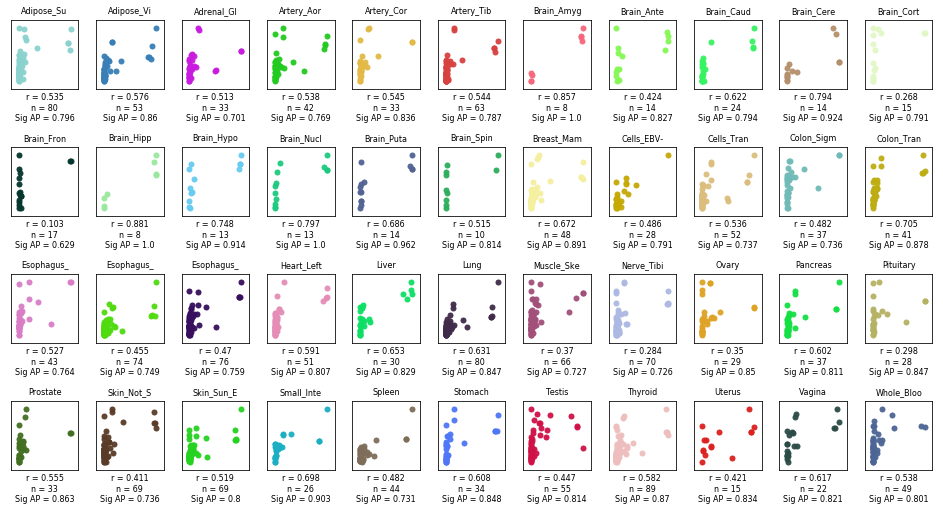

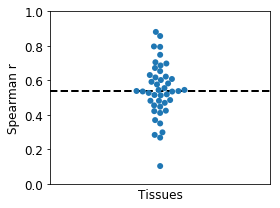

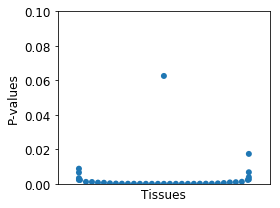

--- example tissue = 'Lung'
spearman r = 0.631
p-value = 3.5568351366618543e-10
n = 80


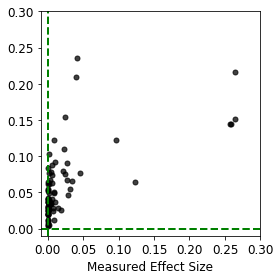

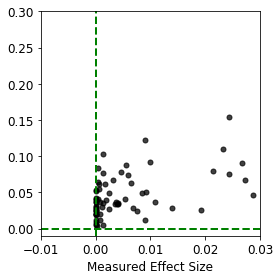

--- example tissue = 'Lung' (calibrated)
spearman r = 0.651
p-value = 6.037400090801922e-11
n = 80


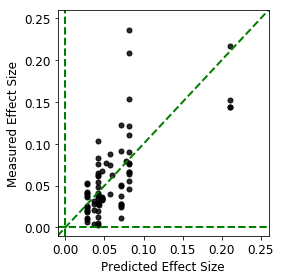

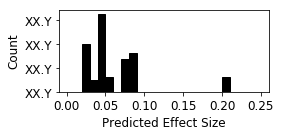

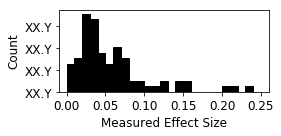

In [12]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = True

version_suffix = '_utr3_iso_lead_all_folds_aparent2_only_abs'

individual_plot_tissue_ix = tissue_types.index("Lung")

min_proximal_padding = 2
n_distal_padding = 2

hl_sign = 1.

significance_q = 0.5

keep_unmapped_snps = True

use_abs = True

rescale_polyadb = False

def _determine_distal_ix(row) :
    
    distal_ix = _get_distal_ix(row['qtl_cut_pos'], gene_cut_pos_dict[row['gene']], cutoff_dist=75)

    return distal_ix if distal_ix != -1 else (dist_index[gene_dict[row['gene']]] if keep_unmapped_snps else -1)

n_rows = 4
n_cols = 11

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

y_preds = []
y_trues = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_dict = {}
snp_tissue_dict = {}

for tissue_i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df_pas = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_only_iso_predictions_pred_df.csv", sep='\t')
    snp_pred_df_pas = snp_pred_df_pas.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_iso = pd.read_csv("predictions/apa_gtex_data/isoform_merged_utr3_only_iso_lead_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')
    snp_pred_df_iso = snp_pred_df_iso.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_pas['snp_pos_pas'] = snp_pred_df_pas['rel_snp_pos'] - 105

    snp_pred_df_pas_orig = snp_pred_df_pas.copy()

    snp_pred_df_pas_distinct = snp_pred_df_pas.copy()
    snp_pred_df_pas_distinct['snp_pos_pas_dist'] = np.abs(snp_pred_df_pas_distinct['snp_pos_pas'] - 76)
    snp_pred_df_pas_distinct = snp_pred_df_pas_distinct.sort_values(by=['snp_pos_pas_dist'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

    snp_pred_df_iso = snp_pred_df_iso.join(snp_pred_df_pas_distinct[['snp_id', 'snp_pos_pas', 'wide_seq_ext', 'wide_seq_ext_var']].drop_duplicates(subset=['snp_id']).set_index('snp_id'), on='snp_id', how='left')
    snp_pred_df_iso.loc[snp_pred_df_iso['snp_pos_pas'].isnull(), 'snp_pos_pas'] = -1

    #snp_pred_df_iso = snp_pred_df_iso.query("snp_pos_pas < 70 or snp_pos_pas > 76").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.query("(snp_pos_pas < 70 or snp_pos_pas > 76) and snp_pos_pas != -1").copy().reset_index(drop=True)
    
    #snp_pred_df_pas = snp_pred_df_pas.query("gene == 'NO_GENE'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.query("gene == 'NO_GENE'").copy().reset_index(drop=True)

    #Get dataframe of unique SNPs
    snp_df = pd.concat([
        snp_pred_df_pas[['snp_id', 'gene_id', 'gene', 'pas', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
        snp_pred_df_iso[['snp_id', 'gene_id', 'gene', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
    ]).drop_duplicates(subset=['snp_id', 'transcript_id'], keep='first').sort_values(by='snp_id').copy().reset_index(drop=True)

    snp_df['distal_ix'] = snp_df.apply(_determine_distal_ix, axis=1)
    snp_df = snp_df.query("distal_ix != -1").copy().reset_index(drop=True)

    #Construct ref/var gene-level matrices for each snp
    s_ref, s_var = np.zeros((len(snp_df), s.shape[1])), np.zeros((len(snp_df), s.shape[1]))
    hl_ref, hl_var = np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3])), np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3]))
    m_ref, m_var = np.zeros((len(snp_df), m.shape[1])), np.zeros((len(snp_df), m.shape[1]))
    l_ref, l_var = np.zeros((len(snp_df), l.shape[1])), np.zeros((len(snp_df), l.shape[1]))
    dist_mask_ref, dist_mask_var = np.zeros((len(snp_df), dist_mask.shape[1])), np.zeros((len(snp_df), dist_mask.shape[1]))

    i = 0
    for _, row in snp_df.iterrows() :

        s_ref[i, :], s_var[i, :] = s[gene_dict[row['gene']], :], s[gene_dict[row['gene']], :]
        hl_ref[i, :], hl_var[i, :] = hl[gene_dict[row['gene']], :, :], hl[gene_dict[row['gene']], :, :]
        m_ref[i, :], m_var[i, :] = m[gene_dict[row['gene']], :], m[gene_dict[row['gene']], :]
        l_ref[i, :], l_var[i, :] = l[gene_dict[row['gene']], :], l[gene_dict[row['gene']], :]
        
        #dist_mask_ref[i, row['distal_ix']], dist_mask_var[i, row['distal_ix']] = 1., 1.
        dist_mask_ref[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1], dist_mask_var[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1] = 1., 1.

        #Fill in variant predictions
        snp_pred_df_pas_subset = snp_pred_df_pas.query("snp_id == '" + row['snp_id'] + "'")
        for _, pas_row in snp_pred_df_pas_subset.iterrows() :

            pred_suffix = '' if gene_id_dict[pas_row['gene_id']] != dist_index[gene_dict[pas_row['gene']]] else '_all_cuts'

            s_ref[i, gene_id_dict[pas_row['gene_id']]] = pas_row['ref_isoform_logodds' + pred_suffix]
            s_var[i, gene_id_dict[pas_row['gene_id']]] = pas_row['var_isoform_logodds' + pred_suffix]

        snp_pred_df_iso_subset = snp_pred_df_iso.query("snp_id == '" + row['snp_id'] + "'")
        for _, iso_row in snp_pred_df_iso_subset.iterrows() :

            model_ix = 0
            for f in range(10) :
                for c in range(5) :
                    for feature_ix in range(hl.shape[3]) :
                        hl_ref[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_ref']
                        hl_var[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_var']

                    model_ix += 1

        i += 1

    snp_df['delta_isoform_logodds'] = np.zeros(len(snp_df))

    for model_ix in range(hl.shape[2]) :
        PDUI_pred_ref = np.clip(_predict(s_ref, hl_sign * hl_ref[..., model_ix, :], m_ref, l_ref, dist_mask_ref, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        PDUI_pred_var = np.clip(_predict(s_var, hl_sign * hl_var[..., model_ix, :], m_var, l_var, dist_mask_var, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        snp_df['delta_isoform_logodds'] += np.log(PDUI_pred_var / (1. - PDUI_pred_var)) - np.log(PDUI_pred_ref / (1. - PDUI_pred_ref))

    snp_df['delta_isoform_logodds'] /= hl.shape[2]
    
    if rescale_polyadb :
        snp_df['delta_isoform_logodds'] *= np.maximum(np.sum(m_ref, axis=-1) - 1., 1.)
    
    snp_df['n_affected'] = np.sum(np.abs(hl_var[..., 0, 0] - hl_ref[..., 0, 0]) > 0., axis=-1)

    snp_pred_df = snp_df.copy()

    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
    
    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    if use_abs :
        lead_snp_pred_df['effect_size_pred'] = np.abs(lead_snp_pred_df['effect_size_pred'])
        lead_snp_pred_df['effect_size'] = np.abs(lead_snp_pred_df['effect_size'])
    
    filtered_df = lead_snp_pred_df
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    for _, row in filtered_df.iterrows() :
        if row['snp_id'] not in snp_dict :
            snp_dict[row['snp_id']] = True
    
    snp_tissue_dict[tissue_type] = filtered_df['snp_id'].values.tolist()
    
    row = tissue_i // n_cols
    col = tissue_i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=significance_q)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(np.abs(filtered_df['effect_size_pred'].values))

    sig_average_precision = average_precision_score(y_labels, y_score)

    if tissue_i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 3)) + "\nn = " + str(int(len(filtered_df))) + "\nSig AP = " + str(round(sig_average_precision, 3)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

spearman_r_vals = np.array(spearman_r_vals)
spearman_p_vals = np.array(spearman_p_vals)
ns = np.array(ns)
sig_ap_vals = np.array(sig_ap_vals)

min_n = 10

print('median spearman r = ' + str(round(np.median(spearman_r_vals[ns >= min_n]), 3)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals[ns >= min_n]), 6)) + ', n = ' + str(total_n))
print('median significance AP = ' + str(round(np.median(sig_ap_vals[ns >= min_n]), 3)))

print("")
print("unique snps = " + str(len(snp_dict)))
print("")

if save_figs :
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)], size=6)

plt.axhline(y=np.median(spearman_r_vals[ns >= min_n]), linestyle='--', linewidth=2, color='black')

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)], size=6)

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix])

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "'")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_trues[individual_plot_tissue_ix].shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.3)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.03, 0.3)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".eps")

plt.show()

#Save r-values, p-values, aps and ns
np.save('gtex_tissue_spearman_r_vals' + version_suffix, spearman_r_vals)
np.save('gtex_tissue_spearman_p_vals' + version_suffix, spearman_p_vals)
np.save('gtex_tissue_ap_vals' + version_suffix, sig_ap_vals)
np.save('gtex_tissue_ns' + version_suffix, ns)

#Calibrate example tissue SNP predictions with isotonic regression
y_pred = y_preds[individual_plot_tissue_ix]
y_true = y_trues[individual_plot_tissue_ix]

#Filter on SNPs which do not occur in chosen example tissue (for isotonic regression)

holdout_set = {snp_id for snp_id in snp_tissue_dict[tissue_types[individual_plot_tissue_ix]]}

y_pred_train = []
y_true_train = []

for tissue_i in range(len(tissue_types)) :
    if tissue_i == individual_plot_tissue_ix :
        continue
    
    if 'Brain' in tissue_types[tissue_i] :
        continue
    
    y_pred_train.append(
        np.array([y_preds[tissue_i][j] for j in range(y_preds[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )
    y_true_train.append(
        np.array([y_trues[tissue_i][j] for j in range(y_trues[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )

y_pred_train = np.concatenate(y_pred_train, axis=0)
y_true_train = np.concatenate(y_true_train, axis=0)

from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip').fit(y_pred_train, y_true_train)
y_pred_iso = iso_reg.predict(y_pred)

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_pred_iso, y_true)

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "' (calibrated)")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_iso, y_true, color='black', s=25, alpha=0.85)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.plot([-0.01, 0.25+0.01], [-0.01, 0.25+0.01], linewidth=2, linestyle='--', color='green')

plt.xlim(-0.01, 0.25+0.01)
plt.ylim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".eps")

plt.show()

#Get densities
histo_pred, bin_edges = np.histogram(y_pred_iso, range=(0., 0.25), bins=25, density=True)
histo_true, _ = np.histogram(y_true, range=(0., 0.25), bins=25, density=True)

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_pred, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_true, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Measured Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".eps")

plt.show()


median spearman r = 0.593, n = 1749.0
median p-value = 4.7e-05, n = 1749.0
median significance AP = 0.821

unique snps = 417



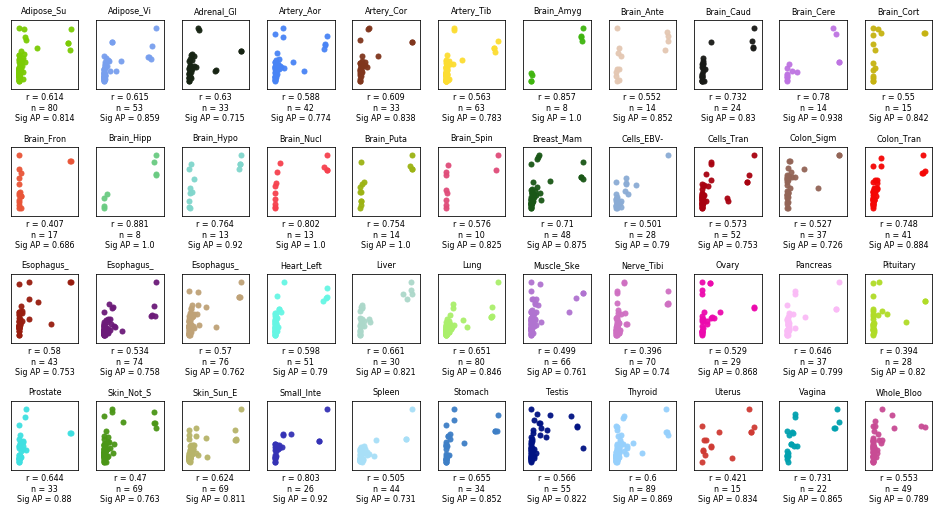

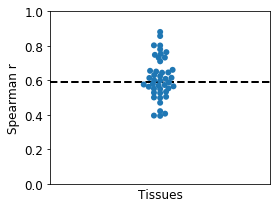

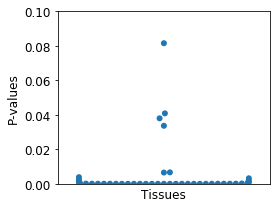

--- example tissue = 'Lung'
spearman r = 0.651
p-value = 6.210160670952604e-11
n = 80


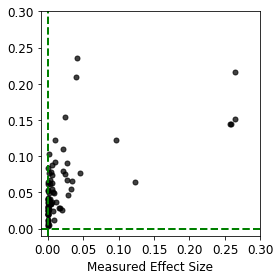

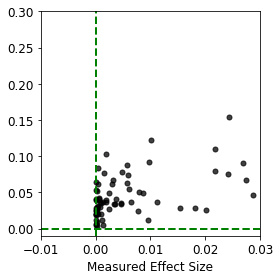

--- example tissue = 'Lung' (calibrated)
spearman r = 0.647
p-value = 8.664159214760291e-11
n = 80


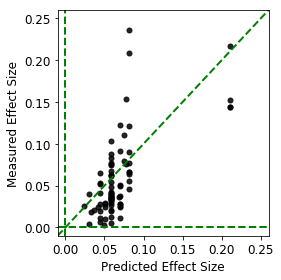

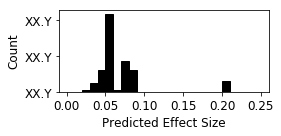

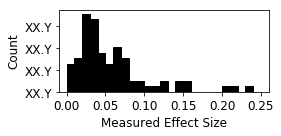

In [13]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = True

version_suffix = '_utr3_iso_lead_all_folds_abs'

individual_plot_tissue_ix = tissue_types.index("Lung")

min_proximal_padding = 2
n_distal_padding = 2

hl_sign = 1.

significance_q = 0.5

keep_unmapped_snps = True

use_abs = True

rescale_polyadb = False

def _determine_distal_ix(row) :
    
    distal_ix = _get_distal_ix(row['qtl_cut_pos'], gene_cut_pos_dict[row['gene']], cutoff_dist=75)

    return distal_ix if distal_ix != -1 else (dist_index[gene_dict[row['gene']]] if keep_unmapped_snps else -1)

n_rows = 4
n_cols = 11

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

y_preds = []
y_trues = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_dict = {}
snp_tissue_dict = {}

for tissue_i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df_pas = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_only_iso_predictions_pred_df.csv", sep='\t')
    snp_pred_df_pas = snp_pred_df_pas.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_iso = pd.read_csv("predictions/apa_gtex_data/isoform_merged_utr3_only_iso_lead_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')
    snp_pred_df_iso = snp_pred_df_iso.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_pas['snp_pos_pas'] = snp_pred_df_pas['rel_snp_pos'] - 105

    snp_pred_df_pas_orig = snp_pred_df_pas.copy()

    snp_pred_df_pas_distinct = snp_pred_df_pas.copy()
    snp_pred_df_pas_distinct['snp_pos_pas_dist'] = np.abs(snp_pred_df_pas_distinct['snp_pos_pas'] - 76)
    snp_pred_df_pas_distinct = snp_pred_df_pas_distinct.sort_values(by=['snp_pos_pas_dist'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

    snp_pred_df_iso = snp_pred_df_iso.join(snp_pred_df_pas_distinct[['snp_id', 'snp_pos_pas', 'wide_seq_ext', 'wide_seq_ext_var']].drop_duplicates(subset=['snp_id']).set_index('snp_id'), on='snp_id', how='left')
    snp_pred_df_iso.loc[snp_pred_df_iso['snp_pos_pas'].isnull(), 'snp_pos_pas'] = -1

    #snp_pred_df_iso = snp_pred_df_iso.query("snp_pos_pas < 70 or snp_pos_pas > 76").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.query("(snp_pos_pas < 70 or snp_pos_pas > 76) and snp_pos_pas != -1").copy().reset_index(drop=True)
    
    #snp_pred_df_pas = snp_pred_df_pas.query("gene == 'NO_GENE'").copy().reset_index(drop=True)
    #snp_pred_df_iso = snp_pred_df_iso.query("gene == 'NO_GENE'").copy().reset_index(drop=True)

    #Get dataframe of unique SNPs
    snp_df = pd.concat([
        snp_pred_df_pas[['snp_id', 'gene_id', 'gene', 'pas', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
        snp_pred_df_iso[['snp_id', 'gene_id', 'gene', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
    ]).drop_duplicates(subset=['snp_id', 'transcript_id'], keep='first').sort_values(by='snp_id').copy().reset_index(drop=True)

    snp_df['distal_ix'] = snp_df.apply(_determine_distal_ix, axis=1)
    snp_df = snp_df.query("distal_ix != -1").copy().reset_index(drop=True)

    #Construct ref/var gene-level matrices for each snp
    s_ref, s_var = np.zeros((len(snp_df), s.shape[1])), np.zeros((len(snp_df), s.shape[1]))
    hl_ref, hl_var = np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3])), np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3]))
    m_ref, m_var = np.zeros((len(snp_df), m.shape[1])), np.zeros((len(snp_df), m.shape[1]))
    l_ref, l_var = np.zeros((len(snp_df), l.shape[1])), np.zeros((len(snp_df), l.shape[1]))
    dist_mask_ref, dist_mask_var = np.zeros((len(snp_df), dist_mask.shape[1])), np.zeros((len(snp_df), dist_mask.shape[1]))

    i = 0
    for _, row in snp_df.iterrows() :

        s_ref[i, :], s_var[i, :] = s[gene_dict[row['gene']], :], s[gene_dict[row['gene']], :]
        hl_ref[i, :], hl_var[i, :] = hl[gene_dict[row['gene']], :, :], hl[gene_dict[row['gene']], :, :]
        m_ref[i, :], m_var[i, :] = m[gene_dict[row['gene']], :], m[gene_dict[row['gene']], :]
        l_ref[i, :], l_var[i, :] = l[gene_dict[row['gene']], :], l[gene_dict[row['gene']], :]
        
        #dist_mask_ref[i, row['distal_ix']], dist_mask_var[i, row['distal_ix']] = 1., 1.
        dist_mask_ref[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1], dist_mask_var[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1] = 1., 1.

        #Fill in variant predictions
        snp_pred_df_pas_subset = snp_pred_df_pas.query("snp_id == '" + row['snp_id'] + "'")
        for _, pas_row in snp_pred_df_pas_subset.iterrows() :

            pred_suffix = '' if gene_id_dict[pas_row['gene_id']] != dist_index[gene_dict[pas_row['gene']]] else '_all_cuts'

            s_ref[i, gene_id_dict[pas_row['gene_id']]] = pas_row['ref_isoform_logodds' + pred_suffix]
            s_var[i, gene_id_dict[pas_row['gene_id']]] = pas_row['var_isoform_logodds' + pred_suffix]

        snp_pred_df_iso_subset = snp_pred_df_iso.query("snp_id == '" + row['snp_id'] + "'")
        for _, iso_row in snp_pred_df_iso_subset.iterrows() :

            model_ix = 0
            for f in range(10) :
                for c in range(5) :
                    for feature_ix in range(hl.shape[3]) :
                        hl_ref[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_ref']
                        hl_var[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_var']

                    model_ix += 1

        i += 1

    snp_df['delta_isoform_logodds'] = np.zeros(len(snp_df))

    for model_ix in range(hl.shape[2]) :
        PDUI_pred_ref = np.clip(_predict(s_ref, hl_sign * hl_ref[..., model_ix, :], m_ref, l_ref, dist_mask_ref, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        PDUI_pred_var = np.clip(_predict(s_var, hl_sign * hl_var[..., model_ix, :], m_var, l_var, dist_mask_var, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        snp_df['delta_isoform_logodds'] += np.log(PDUI_pred_var / (1. - PDUI_pred_var)) - np.log(PDUI_pred_ref / (1. - PDUI_pred_ref))

    snp_df['delta_isoform_logodds'] /= hl.shape[2]
    
    if rescale_polyadb :
        snp_df['delta_isoform_logodds'] *= np.maximum(np.sum(m_ref, axis=-1) - 1., 1.)
    
    snp_df['n_affected'] = np.sum(np.abs(hl_var[..., 0, 0] - hl_ref[..., 0, 0]) > 0., axis=-1)

    snp_pred_df = snp_df.copy()

    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
    
    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    if use_abs :
        lead_snp_pred_df['effect_size_pred'] = np.abs(lead_snp_pred_df['effect_size_pred'])
        lead_snp_pred_df['effect_size'] = np.abs(lead_snp_pred_df['effect_size'])
    
    filtered_df = lead_snp_pred_df
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    for _, row in filtered_df.iterrows() :
        if row['snp_id'] not in snp_dict :
            snp_dict[row['snp_id']] = True
    
    snp_tissue_dict[tissue_type] = filtered_df['snp_id'].values.tolist()
    
    row = tissue_i // n_cols
    col = tissue_i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=significance_q)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(np.abs(filtered_df['effect_size_pred'].values))

    sig_average_precision = average_precision_score(y_labels, y_score)

    if tissue_i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 3)) + "\nn = " + str(int(len(filtered_df))) + "\nSig AP = " + str(round(sig_average_precision, 3)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

spearman_r_vals = np.array(spearman_r_vals)
spearman_p_vals = np.array(spearman_p_vals)
ns = np.array(ns)
sig_ap_vals = np.array(sig_ap_vals)

min_n = 10

print('median spearman r = ' + str(round(np.median(spearman_r_vals[ns >= min_n]), 3)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals[ns >= min_n]), 6)) + ', n = ' + str(total_n))
print('median significance AP = ' + str(round(np.median(sig_ap_vals[ns >= min_n]), 3)))

print("")
print("unique snps = " + str(len(snp_dict)))
print("")

if save_figs :
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)], size=6)

plt.axhline(y=np.median(spearman_r_vals[ns >= min_n]), linestyle='--', linewidth=2, color='black')

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)], size=6)

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix])

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "'")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_trues[individual_plot_tissue_ix].shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.3)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.03, 0.03)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".eps")

plt.show()

#Save r-values, p-values, aps and ns
np.save('gtex_tissue_spearman_r_vals' + version_suffix, spearman_r_vals)
np.save('gtex_tissue_spearman_p_vals' + version_suffix, spearman_p_vals)
np.save('gtex_tissue_ap_vals' + version_suffix, sig_ap_vals)
np.save('gtex_tissue_ns' + version_suffix, ns)

#Calibrate example tissue SNP predictions with isotonic regression
y_pred = y_preds[individual_plot_tissue_ix]
y_true = y_trues[individual_plot_tissue_ix]

#Filter on SNPs which do not occur in chosen example tissue (for isotonic regression)

holdout_set = {snp_id for snp_id in snp_tissue_dict[tissue_types[individual_plot_tissue_ix]]}

y_pred_train = []
y_true_train = []

for tissue_i in range(len(tissue_types)) :
    if tissue_i == individual_plot_tissue_ix :
        continue
    
    if 'Brain' in tissue_types[tissue_i] :
        continue
    
    y_pred_train.append(
        np.array([y_preds[tissue_i][j] for j in range(y_preds[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )
    y_true_train.append(
        np.array([y_trues[tissue_i][j] for j in range(y_trues[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )

y_pred_train = np.concatenate(y_pred_train, axis=0)
y_true_train = np.concatenate(y_true_train, axis=0)

from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip').fit(y_pred_train, y_true_train)
y_pred_iso = iso_reg.predict(y_pred)

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_pred_iso, y_true)

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "' (calibrated)")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_iso, y_true, color='black', s=25, alpha=0.85)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.plot([-0.01, 0.25+0.01], [-0.01, 0.25+0.01], linewidth=2, linestyle='--', color='green')

plt.xlim(-0.01, 0.25+0.01)
plt.ylim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".eps")

plt.show()

#Get densities
histo_pred, bin_edges = np.histogram(y_pred_iso, range=(0., 0.25), bins=25, density=True)
histo_true, _ = np.histogram(y_true, range=(0., 0.25), bins=25, density=True)

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_pred, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_true, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Measured Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".eps")

plt.show()


median spearman r = 0.393, n = 3107.0
median p-value = 0.001472, n = 3107.0
median significance AP = 0.731

unique snps = 1032



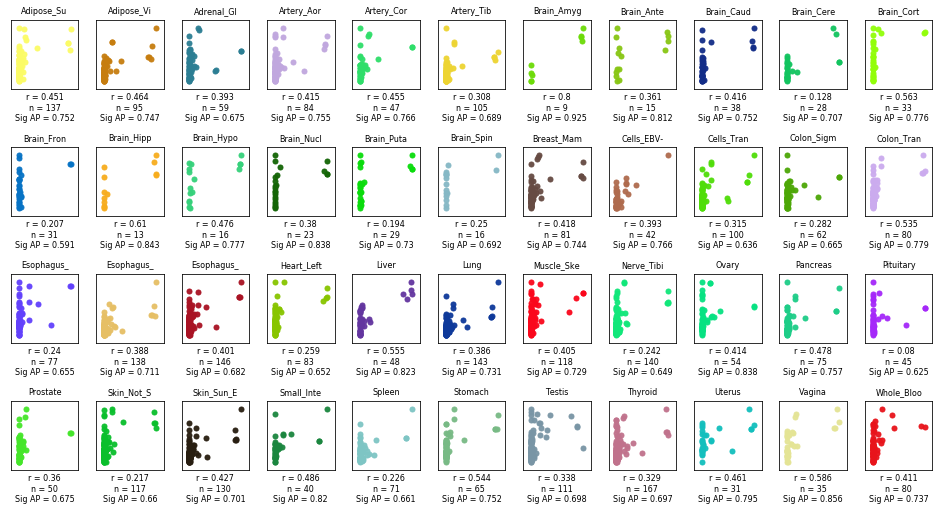

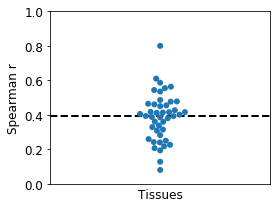

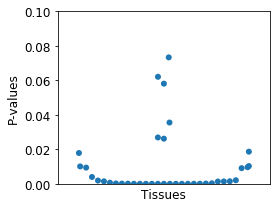

--- example tissue = 'Lung'
spearman r = 0.386
p-value = 1.91969273653911e-06
n = 143


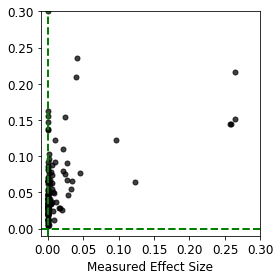

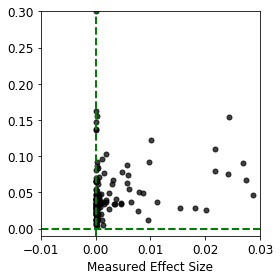

--- example tissue = 'Lung' (calibrated)
spearman r = 0.38
p-value = 2.7935598018554414e-06
n = 143


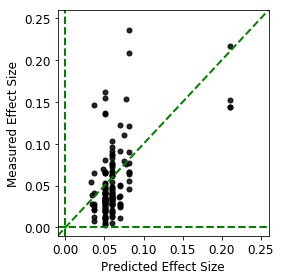

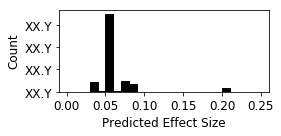

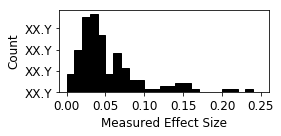

In [14]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = True

version_suffix = '_utr3_iso_lead_all_folds_all_abs'

individual_plot_tissue_ix = tissue_types.index("Lung")

min_proximal_padding = 2
n_distal_padding = 2

hl_sign = 1.

significance_q = 0.5

keep_unmapped_snps = True

use_abs = True

rescale_polyadb = False

def _determine_distal_ix(row) :
    
    distal_ix = _get_distal_ix(row['qtl_cut_pos'], gene_cut_pos_dict[row['gene']], cutoff_dist=75)

    return distal_ix if distal_ix != -1 else (dist_index[gene_dict[row['gene']]] if keep_unmapped_snps else -1)

n_rows = 4
n_cols = 11

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

y_preds = []
y_trues = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_dict = {}
snp_tissue_dict = {}

for tissue_i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df_pas = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_only_iso_predictions_pred_df.csv", sep='\t')
    snp_pred_df_pas = snp_pred_df_pas.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_iso = pd.read_csv("predictions/apa_gtex_data/isoform_merged_utr3_only_iso_lead_SNPs_pred_pmirGLO_construct_dense_full.csv", sep='\t')
    snp_pred_df_iso = snp_pred_df_iso.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)
    
    snp_pred_df_pas['snp_pos_pas'] = snp_pred_df_pas['rel_snp_pos'] - 105

    snp_pred_df_pas_orig = snp_pred_df_pas.copy()

    snp_pred_df_pas_distinct = snp_pred_df_pas.copy()
    snp_pred_df_pas_distinct['snp_pos_pas_dist'] = np.abs(snp_pred_df_pas_distinct['snp_pos_pas'] - 76)
    snp_pred_df_pas_distinct = snp_pred_df_pas_distinct.sort_values(by=['snp_pos_pas_dist'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

    snp_pred_df_iso = snp_pred_df_iso.join(snp_pred_df_pas_distinct[['snp_id', 'snp_pos_pas', 'wide_seq_ext', 'wide_seq_ext_var']].drop_duplicates(subset=['snp_id']).set_index('snp_id'), on='snp_id', how='left')
    snp_pred_df_iso.loc[snp_pred_df_iso['snp_pos_pas'].isnull(), 'snp_pos_pas'] = -1

    snp_pred_df_iso = snp_pred_df_iso.query("snp_pos_pas < 70 or snp_pos_pas > 76").copy().reset_index(drop=True)
    #snp_pred_df_iso = snp_pred_df_iso.query("(snp_pos_pas < 70 or snp_pos_pas > 76) and snp_pos_pas != -1").copy().reset_index(drop=True)
    
    #snp_pred_df_pas = snp_pred_df_pas.query("gene == 'NO_GENE'").copy().reset_index(drop=True)
    #snp_pred_df_iso = snp_pred_df_iso.query("gene == 'NO_GENE'").copy().reset_index(drop=True)

    #Get dataframe of unique SNPs
    snp_df = pd.concat([
        snp_pred_df_pas[['snp_id', 'gene_id', 'gene', 'pas', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
        snp_pred_df_iso[['snp_id', 'gene_id', 'gene', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
    ]).drop_duplicates(subset=['snp_id', 'transcript_id'], keep='first').sort_values(by='snp_id').copy().reset_index(drop=True)

    snp_df['distal_ix'] = snp_df.apply(_determine_distal_ix, axis=1)
    snp_df = snp_df.query("distal_ix != -1").copy().reset_index(drop=True)

    #Construct ref/var gene-level matrices for each snp
    s_ref, s_var = np.zeros((len(snp_df), s.shape[1])), np.zeros((len(snp_df), s.shape[1]))
    hl_ref, hl_var = np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3])), np.zeros((len(snp_df), hl.shape[1], hl.shape[2], hl.shape[3]))
    m_ref, m_var = np.zeros((len(snp_df), m.shape[1])), np.zeros((len(snp_df), m.shape[1]))
    l_ref, l_var = np.zeros((len(snp_df), l.shape[1])), np.zeros((len(snp_df), l.shape[1]))
    dist_mask_ref, dist_mask_var = np.zeros((len(snp_df), dist_mask.shape[1])), np.zeros((len(snp_df), dist_mask.shape[1]))

    i = 0
    for _, row in snp_df.iterrows() :

        s_ref[i, :], s_var[i, :] = s[gene_dict[row['gene']], :], s[gene_dict[row['gene']], :]
        hl_ref[i, :], hl_var[i, :] = hl[gene_dict[row['gene']], :, :], hl[gene_dict[row['gene']], :, :]
        m_ref[i, :], m_var[i, :] = m[gene_dict[row['gene']], :], m[gene_dict[row['gene']], :]
        l_ref[i, :], l_var[i, :] = l[gene_dict[row['gene']], :], l[gene_dict[row['gene']], :]
        
        #dist_mask_ref[i, row['distal_ix']], dist_mask_var[i, row['distal_ix']] = 1., 1.
        dist_mask_ref[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1], dist_mask_var[i, max(min(min_proximal_padding, row['distal_ix']), row['distal_ix']-n_distal_padding):row['distal_ix']+1] = 1., 1.

        #Fill in variant predictions
        snp_pred_df_pas_subset = snp_pred_df_pas.query("snp_id == '" + row['snp_id'] + "'")
        for _, pas_row in snp_pred_df_pas_subset.iterrows() :

            pred_suffix = '' if gene_id_dict[pas_row['gene_id']] != dist_index[gene_dict[pas_row['gene']]] else '_all_cuts'

            s_ref[i, gene_id_dict[pas_row['gene_id']]] = pas_row['ref_isoform_logodds' + pred_suffix]
            s_var[i, gene_id_dict[pas_row['gene_id']]] = pas_row['var_isoform_logodds' + pred_suffix]

        snp_pred_df_iso_subset = snp_pred_df_iso.query("snp_id == '" + row['snp_id'] + "'")
        for _, iso_row in snp_pred_df_iso_subset.iterrows() :

            model_ix = 0
            for f in range(10) :
                for c in range(5) :
                    for feature_ix in range(hl.shape[3]) :
                        hl_ref[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_ref']
                        hl_var[i, gene_id_dict[iso_row['gene_id']], model_ix, feature_ix] = iso_row['isoform_hl_f' + str(f) + '_c' + str(c) + '_feature_' + str(feature_ix) + '_var']

                    model_ix += 1

        i += 1

    snp_df['delta_isoform_logodds'] = np.zeros(len(snp_df))

    for model_ix in range(hl.shape[2]) :
        PDUI_pred_ref = np.clip(_predict(s_ref, hl_sign * hl_ref[..., model_ix, :], m_ref, l_ref, dist_mask_ref, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        PDUI_pred_var = np.clip(_predict(s_var, hl_sign * hl_var[..., model_ix, :], m_var, l_var, dist_mask_var, pcas[model_ix], w_dicts[model_ix]), 1e-7, 1. - 1e-7)
        snp_df['delta_isoform_logodds'] += np.log(PDUI_pred_var / (1. - PDUI_pred_var)) - np.log(PDUI_pred_ref / (1. - PDUI_pred_ref))

    snp_df['delta_isoform_logodds'] /= hl.shape[2]
    
    if rescale_polyadb :
        snp_df['delta_isoform_logodds'] *= np.maximum(np.sum(m_ref, axis=-1) - 1., 1.)
    
    snp_df['n_affected'] = np.sum(np.abs(hl_var[..., 0, 0] - hl_ref[..., 0, 0]) > 0., axis=-1)

    snp_pred_df = snp_df.copy()

    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
    
    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    if use_abs :
        lead_snp_pred_df['effect_size_pred'] = np.abs(lead_snp_pred_df['effect_size_pred'])
        lead_snp_pred_df['effect_size'] = np.abs(lead_snp_pred_df['effect_size'])
    
    filtered_df = lead_snp_pred_df
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    for _, row in filtered_df.iterrows() :
        if row['snp_id'] not in snp_dict :
            snp_dict[row['snp_id']] = True
    
    snp_tissue_dict[tissue_type] = filtered_df['snp_id'].values.tolist()
    
    row = tissue_i // n_cols
    col = tissue_i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=significance_q)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(np.abs(filtered_df['effect_size_pred'].values))

    sig_average_precision = average_precision_score(y_labels, y_score)

    if tissue_i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 3)) + "\nn = " + str(int(len(filtered_df))) + "\nSig AP = " + str(round(sig_average_precision, 3)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

spearman_r_vals = np.array(spearman_r_vals)
spearman_p_vals = np.array(spearman_p_vals)
ns = np.array(ns)
sig_ap_vals = np.array(sig_ap_vals)

min_n = 10

print('median spearman r = ' + str(round(np.median(spearman_r_vals[ns >= min_n]), 3)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals[ns >= min_n]), 6)) + ', n = ' + str(total_n))
print('median significance AP = ' + str(round(np.median(sig_ap_vals[ns >= min_n]), 3)))

print("")
print("unique snps = " + str(len(snp_dict)))
print("")

if save_figs :
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)], size=6)

plt.axhline(y=np.median(spearman_r_vals[ns >= min_n]), linestyle='--', linewidth=2, color='black')

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)], size=6)

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix])

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "'")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_trues[individual_plot_tissue_ix].shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.3)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

if use_abs :
    plt.xlim(-0.01, 0.03)
    plt.ylim(-0.01, 0.3)
else :
    plt.xlim(-0.03, 0.03)
    plt.ylim(-0.3, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_zoom" + version_suffix + ".eps")

plt.show()

#Save r-values, p-values, aps and ns
np.save('gtex_tissue_spearman_r_vals' + version_suffix, spearman_r_vals)
np.save('gtex_tissue_spearman_p_vals' + version_suffix, spearman_p_vals)
np.save('gtex_tissue_ap_vals' + version_suffix, sig_ap_vals)
np.save('gtex_tissue_ns' + version_suffix, ns)

#Calibrate example tissue SNP predictions with isotonic regression
y_pred = y_preds[individual_plot_tissue_ix]
y_true = y_trues[individual_plot_tissue_ix]

#Filter on SNPs which do not occur in chosen example tissue (for isotonic regression)

holdout_set = {snp_id for snp_id in snp_tissue_dict[tissue_types[individual_plot_tissue_ix]]}

y_pred_train = []
y_true_train = []

for tissue_i in range(len(tissue_types)) :
    if tissue_i == individual_plot_tissue_ix :
        continue
    
    if 'Brain' in tissue_types[tissue_i] :
        continue
    
    y_pred_train.append(
        np.array([y_preds[tissue_i][j] for j in range(y_preds[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )
    y_true_train.append(
        np.array([y_trues[tissue_i][j] for j in range(y_trues[tissue_i].shape[0]) if snp_tissue_dict[tissue_types[tissue_i]][j] not in holdout_set])
    )

y_pred_train = np.concatenate(y_pred_train, axis=0)
y_true_train = np.concatenate(y_true_train, axis=0)

from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip').fit(y_pred_train, y_true_train)
y_pred_iso = iso_reg.predict(y_pred)

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_pred_iso, y_true)

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "' (calibrated)")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred_iso, y_true, color='black', s=25, alpha=0.85)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.plot([-0.01, 0.25+0.01], [-0.01, 0.25+0.01], linewidth=2, linestyle='--', color='green')

plt.xlim(-0.01, 0.25+0.01)
plt.ylim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_calibrated" + version_suffix + ".eps")

plt.show()

#Get densities
histo_pred, bin_edges = np.histogram(y_pred_iso, range=(0., 0.25), bins=25, density=True)
histo_true, _ = np.histogram(y_true, range=(0., 0.25), bins=25, density=True)

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_pred, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_pred" + version_suffix + ".eps")

plt.show()

f = plt.figure(figsize=(4, 2))

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[1:] - bin_width/2., histo_true, width=bin_width, color='black', edgecolor='black', linewidth=1)

plt.xlim(-0.01, 0.25+0.01)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Measured Effect Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

from matplotlib.ticker import FormatStrFormatter

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('XX.Y'))#%.1f

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example_density_true" + version_suffix + ".eps")

plt.show()


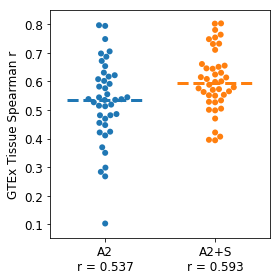

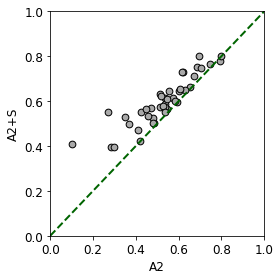

median AP ratio = 1.007


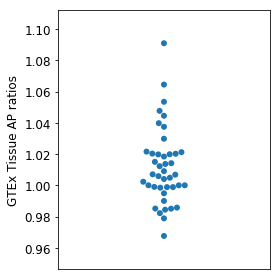

In [15]:
#Compare r-values w vs. w/o saluki model

save_figs = True

benchmark_save_suffix = "_all_folds"

model_names = [
    'A2',
    'A2+S',
]

save_suffixes = [
    '_utr3_iso_lead_all_folds_aparent2_only_abs',
    '_utr3_iso_lead_all_folds_abs',
]

max_p_val = None
min_n = 10

r_vals = []
ap_vals = []
r_medians = []

for i, [model_name, version_suffix] in enumerate(zip(model_names, save_suffixes)) :
    
    rs = np.load('gtex_tissue_spearman_r_vals' + version_suffix + '.npy')
    ps = np.load('gtex_tissue_spearman_p_vals' + version_suffix + '.npy')
    aps = np.load('gtex_tissue_ap_vals' + version_suffix + '.npy')
    ns = np.load('gtex_tissue_ns' + version_suffix + '.npy')
    
    if max_p_val is not None :
        r_vals.append(rs[ps < max_p_val])
        ap_vals.append(aps[ps < max_p_val])
        r_medians.append(np.median(rs[ps < max_p_val]))
    elif min_n is not None :
        r_vals.append(rs[ns >= min_n])
        ap_vals.append(aps[ns >= min_n])
        r_medians.append(np.median(rs[ns >= min_n]))
    else :
        r_vals.append(rs)
        ap_vals.append(aps)
        r_medians.append(np.median(rs))

import seaborn as sns

#Swarm plots of r-values
f = plt.figure(figsize=(4, 4))

ax = sns.swarmplot(data=r_vals, size=6)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, r_m in enumerate(r_medians) :
    plt.plot([i - 0.35, i + 0.35], [r_m, r_m], linewidth=3, linestyle="--", color=colors[i])

plt.xticks(np.arange(len(r_vals)), [m.upper()[:11] + "\nr = " + str(round(r_medians[m_i], 3)) for m_i, m in enumerate(model_names)], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(0., 1.)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_benchmark_r_value_swarms" + benchmark_save_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_benchmark_r_value_swarms" + benchmark_save_suffix + ".eps")

plt.show()

#Scatter plot of r-values
f = plt.figure(figsize=(4, 4))

plt.scatter(r_vals[0], r_vals[1], color='darkgray', edgecolor='black', linewidth=1, s=45)

plt.plot([0, 1], [0, 1], linewidth=2, color='darkgreen', linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel(model_names[0].upper(), fontsize=12)
plt.ylabel(model_names[1].upper(), fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_benchmark_r_value_scatter" + benchmark_save_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_benchmark_r_value_scatter" + benchmark_save_suffix + ".eps")

plt.show()

#Swarm plots of AP ratios
f = plt.figure(figsize=(4, 4))

print("median AP ratio = " + str(round(np.median(ap_vals[1] / ap_vals[0]), 3)))

ax = sns.swarmplot(data=[ap_vals[1] / ap_vals[0]], size=6)

plt.xticks([], [])
plt.yticks(fontsize=12)

#plt.ylim(0., 1.)

plt.ylabel("GTEx Tissue AP ratios", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_benchmark_apr_swarm" + benchmark_save_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_benchmark_apr_swarm" + benchmark_save_suffix + ".eps")

plt.show()
